In [420]:
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

### 1) EXACT APPROACH: BRANCH-AND-BOUND $^{3}$

In [453]:
from ortools.algorithms import pywrapknapsack_solver

In [454]:
values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]
weights = [[
    7, 0, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 0, 36, 3, 8, 15, 42, 9, 0,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 0, 79, 20, 65, 52, 13
]]
capacities = [850]

In [455]:
def knapsack_solver(values, weights, capacities, is_detail=False):
    solver = pywrapknapsack_solver.KnapsackSolver(
        pywrapknapsack_solver.KnapsackSolver.
        KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER, 'KnapsackExample')

    solver.Init(values, weights, capacities)
    computed_value = solver.Solve()
    
    total_weight = 0
    if is_detail == True:
        packed_weights = []
        for i in range(len(values)):
            if solver.BestSolutionContains(i):
                packed_weights.append(weights[0][i])
                total_weight += weights[0][i]
            else:
                packed_weights.append(-1)
    else:
        packed_weights = None
        for i in range(len(values)):
            if solver.BestSolutionContains(i):
                total_weight += weights[0][i]

    return computed_value, total_weight, packed_weights

In [456]:
computed_value_simple, total_weight_simple, packed_weights_simple = knapsack_solver(values, weights, capacities, True)

print('computed_value:', computed_value_simple)
print('total_weight:', total_weight_simple)
print('packed_weights:', packed_weights_simple)

computed_value: 7534
total_weight: 850
packed_weights: [7, 0, -1, 22, 80, -1, 11, -1, -1, -1, 59, 18, 0, -1, 3, 8, 15, 42, 9, 0, -1, 47, 52, -1, 26, -1, -1, 6, 29, 84, 2, 4, 18, -1, 7, -1, -1, -1, 71, 3, -1, 66, 31, -1, 0, -1, -1, 65, 52, 13]


### 2) WHEN UNCERTAINTY APPEARS

In [500]:
# init variables
# will also be used in section (3) below

N = len(values)
delta = 0.2 * np.array(weights[0])
num_samp = 1000
zs = 1-2*rd.rand(num_samp, N) # random samples for z

In [502]:
computed_value_ro_simple = []
total_weight_ro_simple = []
mean_deviation_ro_simple = []
weights_ro_simple = []
for idx in range(num_samp):
    
    temp_weights_ro_simple = [list((np.array(weights[0]) + zs[idx] * delta).astype('int'))]
    temp_mean_deviation_ro_simple = (abs(zs[idx] * delta).sum()) / N
    computed_value, total_weight, _ = knapsack_solver(
        values, temp_weights_ro_simple, capacities, False
    )

    computed_value_ro_simple.append(computed_value)
    total_weight_ro_simple.append(total_weight)
    mean_deviation_ro_simple.append(temp_mean_deviation_ro_simple)
    weights_ro_simple.append(sum(temp_weights_ro_simple[0]))

In [509]:
df_ro_simple = pd.DataFrame(list(zip(weights_ro_simple, computed_value_ro_simple, total_weight_ro_simple , mean_deviation_ro_simple)), 
                            columns=['weights_with_uncertainty', 'computed_value', 'total_weight', 'mean_deviation_from_original_weight'])
df_ro_simple['is_greater_than_baseline_value'] = np.where(df_ro_simple['computed_value'] > computed_value_simple, 1, 0)
df_ro_simple['is_greater_than_baseline_weights'] = np.where(df_ro_simple['weights_with_uncertainty'] > np.array(weights[0]).sum(), 1, 0)
df_ro_simple

,weights_with_uncertainty,computed_value,total_weight,mean_deviation_from_original_weight,is_greater_than_baseline_value,is_greater_than_baseline_weights
0,1818,7623,848,3.565487,1,0
1,1874,7562,850,3.800790,1,0
2,1857,7622,849,3.745456,1,0
3,1923,7415,847,3.860280,0,1
4,1874,7512,844,3.891389,0,0
...,...,...,...,...,...,...
995,1911,7604,841,4.063224,1,1
996,1899,7512,846,3.804794,0,1
997,1861,7623,846,3.920726,1,0
998,1779,7682,843,3.456099,1,0


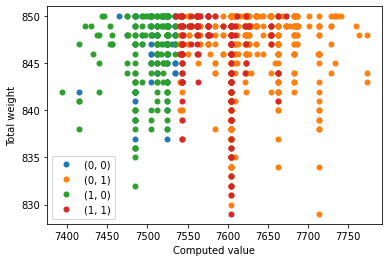

In [510]:
groups = df_ro_simple.groupby(['is_greater_than_baseline_weights', 'is_greater_than_baseline_value'])
for name, group in groups:
    plt.plot(group.computed_value, group.total_weight, marker='o', linestyle='', markersize=5, label=name)
plt.xlabel('Computed value')
plt.ylabel('Total weight')
plt.legend()

### 2A) LET'S SEE A BIT DEEPER

In [514]:
# check 1st case
idx1 = df_ro_simple[(df_ro_simple['is_greater_than_baseline_weights'] == 0) & 
                    (df_ro_simple['is_greater_than_baseline_value'] == 0)].index[0]
df_ro_simple.iloc[idx1]

weights_with_uncertainty               1874.000000
computed_value                         7512.000000
total_weight                            844.000000
mean_deviation_from_original_weight       3.891389
is_greater_than_baseline_value            0.000000
is_greater_than_baseline_weights          0.000000
Name: 4, dtype: float64

In [515]:
temp_weights_ro_simple = [list((np.array(weights[0]) + zs[idx1] * delta).astype('int'))]
temp_mean_deviation_ro_simple = (abs(zs[idx1] * delta).sum()) / N
computed_value1, total_weight1, packed_weights1 = knapsack_solver(
    values, temp_weights_ro_simple, capacities, True
)
print('mean_deviation:', temp_mean_deviation_ro_simple)
print('computed_value:', computed_value1)
print('total_weight:', total_weight1)
print('packed_weights:', packed_weights1)
print('num_of_packed_weights:', np.array(packed_weights1)[(np.array(packed_weights1) > -1)].shape)

mean_deviation: 3.891388696775448
computed_value: 7512
total_weight: 844
packed_weights: [7, 0, -1, 24, 89, -1, 11, -1, -1, -1, 70, 20, 0, -1, 3, 9, 14, 49, 10, 0, 46, 46, 60, -1, -1, -1, -1, 5, -1, 73, 2, 3, 18, -1, 7, -1, -1, -1, 73, 3, -1, 54, 29, -1, 0, -1, -1, 54, 51, 14]
num_of_packed_weights: (31,)


In [516]:
# check 2nd case
idx2 = df_ro_simple[(df_ro_simple['is_greater_than_baseline_weights'] == 0) & 
                    (df_ro_simple['is_greater_than_baseline_value'] == 1)].index[0]
df_ro_simple.iloc[idx2]

weights_with_uncertainty               1818.000000
computed_value                         7623.000000
total_weight                            848.000000
mean_deviation_from_original_weight       3.565487
is_greater_than_baseline_value            1.000000
is_greater_than_baseline_weights          0.000000
Name: 0, dtype: float64

In [517]:
temp_weights_ro_simple = [list((np.array(weights[0]) + zs[idx2] * delta).astype('int'))]
temp_mean_deviation_ro_simple = (abs(zs[idx2] * delta).sum()) / N
computed_value2, total_weight2, packed_weights2 = knapsack_solver(
    values, temp_weights_ro_simple, capacities, True
)
print('mean_deviation:', temp_mean_deviation_ro_simple)
print('computed_value:', computed_value2)
print('total_weight:', total_weight2)
print('packed_weights:', packed_weights2)
print('num_of_packed_weights:', np.array(packed_weights2)[(np.array(packed_weights2) > -1)].shape)

mean_deviation: 3.565487214319002
computed_value: 7623
total_weight: 848
packed_weights: [7, 0, -1, 24, 80, -1, 11, -1, -1, -1, 59, 16, 0, -1, 3, 8, 15, 37, 7, 0, 49, 48, 45, -1, 24, -1, -1, 5, -1, 75, 2, 3, 20, -1, 7, -1, -1, -1, 81, 2, -1, 56, 25, -1, 0, -1, 20, 57, 51, 11]
num_of_packed_weights: (33,)


In [521]:
# check 3rd case
idx3 = df_ro_simple[(df_ro_simple['is_greater_than_baseline_weights'] == 1) & 
                    (df_ro_simple['is_greater_than_baseline_value'] == 0)].index[0]
df_ro_simple.iloc[idx3]

weights_with_uncertainty               1923.00000
computed_value                         7415.00000
total_weight                            847.00000
mean_deviation_from_original_weight       3.86028
is_greater_than_baseline_value            0.00000
is_greater_than_baseline_weights          1.00000
Name: 3, dtype: float64

In [522]:
temp_weights_ro_simple = [list((np.array(weights[0]) + zs[idx3] * delta).astype('int'))]
temp_mean_deviation_ro_simple = (abs(zs[idx3] * delta).sum()) / N
computed_value3, total_weight3, packed_weights3 = knapsack_solver(
    values, temp_weights_ro_simple, capacities, True
)
print('mean_deviation:', temp_mean_deviation_ro_simple)
print('computed_value:', computed_value3)
print('total_weight:', total_weight3)
print('packed_weights:', packed_weights3)
print('num_of_packed_weights:', np.array(packed_weights3)[(np.array(packed_weights3) > -1)].shape)

mean_deviation: 3.8602798001302987
computed_value: 7415
total_weight: 847
packed_weights: [8, 0, -1, 21, 90, -1, 10, -1, -1, -1, 65, 18, 0, -1, 3, 7, 16, 42, 9, 0, 49, 52, 62, -1, 28, -1, -1, 5, -1, 92, 1, 4, 16, -1, 7, -1, -1, -1, 72, 3, -1, -1, 36, -1, 0, -1, -1, 61, 55, 15]
num_of_packed_weights: (31,)


In [524]:
# check 4th case
idx4 = df_ro_simple[(df_ro_simple['is_greater_than_baseline_weights'] == 1) & 
                    (df_ro_simple['is_greater_than_baseline_value'] == 1)].index[0]
df_ro_simple.iloc[idx4]

weights_with_uncertainty               1887.000000
computed_value                         7554.000000
total_weight                            849.000000
mean_deviation_from_original_weight       3.982337
is_greater_than_baseline_value            1.000000
is_greater_than_baseline_weights          1.000000
Name: 7, dtype: float64

In [526]:
temp_weights_ro_simple = [list((np.array(weights[0]) + zs[idx4] * delta).astype('int'))]
temp_mean_deviation_ro_simple = (abs(zs[idx4] * delta).sum()) / N
computed_value4, total_weight4, packed_weights4 = knapsack_solver(
    values, temp_weights_ro_simple, capacities, True
)
print('mean_deviation:', temp_mean_deviation_ro_simple)
print('computed_value:', computed_value4)
print('total_weight:', total_weight4)
print('packed_weights:', packed_weights4)
print('num_of_packed_weights:', np.array(packed_weights4)[(np.array(packed_weights4) > -1)].shape)

[[6, 0, 32, 19, 91, 112, 11, 80, 62, 60, 60, 16, 0, 36, 2, 6, 17, 35, 9, 0, 40, 54, 42, 38, 21, 43, 44, 6, 29, 94, 1, 4, 15, 59, 6, 29, 110, 40, 82, 3, 85, 56, 29, 64, 0, 88, 17, 76, 48, 10]]
mean_deviation: 3.982336794421586
computed_value: 7554
total_weight: 849
packed_weights: [6, 0, -1, 19, 91, -1, 11, -1, -1, -1, 60, 16, 0, -1, 2, 6, 17, 35, 9, 0, 40, 54, 42, -1, 21, 43, -1, 6, 29, 94, 1, 4, 15, -1, 6, -1, -1, -1, -1, 3, -1, 56, 29, -1, 0, -1, -1, 76, 48, 10]
num_of_packed_weights: (33,)


### 3) ROBUST OPTIMIZATION $^{4}$

In [518]:
from rsome import ro
from rsome import ort_solver as ort
import rsome as rso

In [527]:
N = len(values)
capacities_ro = capacities[0]

values_ro = np.array(values)
weights_ro = np.array(weights[0])
delta_ro = 0.2 * weights_ro

In [528]:
def robust(r):
    """
    The function robust implements the robust optimiztion model,
    given the budget of uncertainty r
    """

    model = ro.Model('robust')
    x = model.dvar(N, vtype='B')    
    z = model.rvar(N)              

    z_set = (abs(z) <= 1, rso.norm(z, 1) <= r)
    model.max(values_ro @ x)
    model.st(((weights_ro + z * delta) @ x <= capacities_ro).forall(z_set))

    model.solve(ort, display=False)

    return model.get(), x.get()     # the optimal objective and solution

In [529]:
def sim(x_sol, zs):
    """
    The function sim is for calculating the probability of violation
    via simulations.
        x_sol: solution of the Knapsack problem
        zs: random sample of the random variable z
    """

    weights_sample_ro = weights_ro + zs*delta   # random samples of uncertain weights

    return (weights_sample_ro @ x_sol > capacities_ro).mean()

In [537]:
step = 0.1
rs = np.arange(0, 5+step, step)

"""Robust optimization"""
outputs_rb = [robust(r) for r in rs]
computed_value_ro = [output[0] for output in outputs_rb]      
total_weight_ro = [(output[1] * weights_ro).sum() for output in outputs_rb]
prob_violation_ro = [sim(output[1], zs) for output in outputs_rb]

In [538]:
# compare result with no uncertainty budget (should be similar to previous approach)
# packed_weights from previous approach - only the one considered as part of solution: 
# [7, 0, 22, 80, 11, 59, 18, 0, 3, 8, 15, 42, 9, 0, 47, 52, 26, 6, 29, 84, 2, 4, 18, 7, 71, 3, 66, 31, 0, 65, 52, 13]

print(outputs_rb[0][1] * weights_ro)

[ 7.  0. -0. 22. 80.  0. 11.  0.  0.  0. 59. 18.  0.  0.  3.  8. 15. 42.
  9.  0. -0. 47. 52.  0. 26. -0.  0.  6. 29. 84.  2.  4. 18.  0.  7.  0.
  0.  0. 71.  3.  0. 66. 31.  0.  0.  0.  0. 65. 52. 13.]


In [539]:
df_ro = pd.DataFrame(list(zip(rs, computed_value_ro, total_weight_ro, prob_violation_ro)), 
                     columns =['uncertainty_budget', 'computed_value', 'total_weight', 'probability_violation'])
df_ro

,uncertainty_budget,computed_value,total_weight,probability_violation
0,0.0,7534.0,850.0,0.500
1,0.1,7526.0,848.0,0.471
2,0.2,7525.0,845.0,0.426
3,0.3,7512.0,837.0,0.314
4,0.4,7512.0,837.0,0.314
5,0.5,7512.0,837.0,0.314
6,0.6,7512.0,837.0,0.314
7,0.7,7512.0,837.0,0.314
8,0.8,7484.0,821.0,0.115
9,0.9,7484.0,821.0,0.115


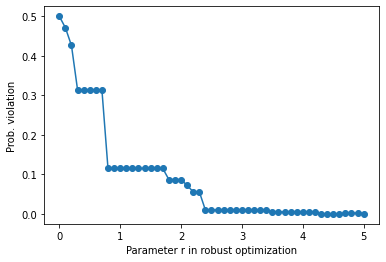

In [540]:
plt.scatter(rs, prob_violation_ro, marker='o')
plt.plot(rs, prob_violation_ro)
plt.xlabel('Parameter r in robust optimization')
plt.ylabel('Prob. violation')
plt.show()

### 4) REFERENCES:
1. https://pubsonline.informs.org/doi/abs/10.1287/opre.1030.0065
2. http://www.optimization-online.org/DB_FILE/2021/06/8443.pdf
3. https://developers.google.com/optimization/bin/knapsack
4. https://xiongpengnus.github.io/rsome/example_ro_knapsack